In [5]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [6]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from new_train import train_nis
from new_train import train_nisp_rnis
from nis_net import NISNet
from nis_net import NISPNet
from nis_net import RNISNet
from datetime import datetime
from new_sir import SIRModel
from new_kuromoto import KuromotoModel
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate SIR data

In [ ]:
sigma = 0.03
rou = -0.5
steps = 7
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
sir_train = SIRModel(size_list=[8000], beta=1, gamma=0.5, steps=7, dt=dt, interval=1, sigma=sigma, rho=-0.5)
train_data = [torch.FloatTensor(sir_train.sir_input).to(device), torch.FloatTensor(sir_train.sir_output).to(device)]
sir_test = SIRModel(size_list=[1000], beta=1, gamma=0.5, steps=7, dt=dt, interval=1, sigma=sigma, rho=-0.5)
test_data = [torch.FloatTensor(sir_test.sir_input).to(device), torch.FloatTensor(sir_test.sir_output).to(device)]

# Generate Kuromoto data

In [7]:
rou = -0.5
steps = 7
dt = 0.01
sz = 16
groups = 2
coupling = 0.3

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
kur_train = KuromotoModel(size_list=[8000], steps=1000, dt=dt, interval=1, rho=-0.5, sz=sz, groups=groups, coupling=coupling)
train_data = [torch.FloatTensor(kur_train.input).to(device), torch.FloatTensor(kur_train.output).to(device)]
kur_test = KuromotoModel(size_list=[1000], steps=7, dt=dt, interval=1, rho=-0.5, sz=sz, groups=groups, coupling=coupling)
test_data = [torch.FloatTensor(kur_test.input).to(device), torch.FloatTensor(kur_test.output).to(device)]

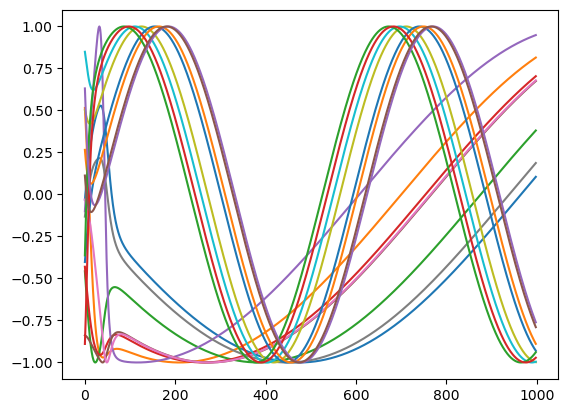

In [8]:
plt.plot(kur_train.input)

# Train RNIS

In [9]:
# train params

T_total = 15001
clip = 300

In [10]:
sz = 16
scale = 2
hidden_units = 64
batch_size = 128

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_rnis = RNISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=32,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_rnis, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=1, batch_size=batch_size, clip=clip)
eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis = trainer.return_log()
param_counts_rnis = trainer.param_counts

check point------step-> 23:34:03.662435; lasting 0:02:39.246077 seconds
Epoch: 300
Train loss: 0.7093
Train loss: 0.6758
dEI: 1.0356
term1: 0.4102
term2: 1.6610
------------------------------------------------------------------------------------------------------------------------
check point------step-> 23:34:12.028869; lasting 0:00:08.366434 seconds
Epoch: 600
Train loss: 0.5266
Train loss: 0.6462
dEI: 0.8439
term1: -0.0994
term2: 1.7873
------------------------------------------------------------------------------------------------------------------------
check point------step-> 23:34:20.399291; lasting 0:00:08.370422 seconds
Epoch: 900
Train loss: 0.4833
Train loss: 0.5711
dEI: 0.9120
term1: 0.0547
term2: 1.7692
------------------------------------------------------------------------------------------------------------------------
check point------step-> 23:34:28.814758; lasting 0:00:08.415467 seconds
Epoch: 1200
Train loss: 0.4703
Train loss: 0.6004
dEI: 0.6939
term1: -0.5547
term

# Train NIS

In [12]:
sz = 16
scale = 2
hidden_units = 64
batch_size = 128

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nis = NISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, is_normalized=True)
trainer = train_nis(net=net_nis, data=train_data, data_test=test_data, device=device)
trainer.training(T_all=T_total, batch_size=batch_size, clip=clip)
eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = trainer.return_log()
param_counts_nis = trainer.param_counts

check point------step-> 00:54:06.661662; lasting 1:11:52.571994 seconds
Epoch: 0
Train loss: 0.0031
Train loss: 0.9766
dEI: 0.1055
term1: -1.1840
term2: 1.3950
------------------------------------------------------------------------------------------------------------------------
check point------step-> 00:54:12.960831; lasting 0:00:06.299169 seconds
Epoch: 300
Train loss: 0.7084
Train loss: 0.6661
dEI: 1.5290
term1: 1.4833
term2: 1.5747
------------------------------------------------------------------------------------------------------------------------
check point------step-> 00:54:19.289787; lasting 0:00:06.328956 seconds
Epoch: 600
Train loss: 0.5214
Train loss: 0.6513
dEI: 1.8534
term1: 2.0196
term2: 1.6872
------------------------------------------------------------------------------------------------------------------------
check point------step-> 00:54:25.609275; lasting 0:00:06.319488 seconds
Epoch: 900
Train loss: 0.4704
Train loss: 0.5696
dEI: 1.3372
term1: 0.8726
term2: 1

# Train NIS+

In [13]:
sz = 16
scale = 2
hidden_units = 64
batch_size = 128

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nisp = NISPNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=hidden_units,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_nisp, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=1, batch_size=batch_size, clip=clip)
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = trainer.return_log()
param_counts_nisp = trainer.param_counts

check point------step-> 00:59:20.446219; lasting 0:00:00.589371 seconds
Epoch: 0
Train loss: 0.0031
Train loss: 0.9766
dEI: 0.1055
term1: -1.1840
term2: 1.3950
------------------------------------------------------------------------------------------------------------------------
check point------step-> 00:59:26.564238; lasting 0:00:06.118019 seconds
Epoch: 300
Train loss: 0.7084
Train loss: 0.6661
dEI: 1.5290
term1: 1.4833
term2: 1.5747
------------------------------------------------------------------------------------------------------------------------
check point------step-> 00:59:32.734489; lasting 0:00:06.170251 seconds
Epoch: 600
Train loss: 0.5214
Train loss: 0.6513
dEI: 1.8534
term1: 2.0196
term2: 1.6872
------------------------------------------------------------------------------------------------------------------------
check point------step-> 00:59:38.956778; lasting 0:00:06.222289 seconds
Epoch: 900
Train loss: 0.4704
Train loss: 0.5696
dEI: 1.3372
term1: 0.8726
term2: 1

# Results

In [14]:
print(param_counts_nis, param_counts_nisp, param_counts_rnis)

42210 46692 42600


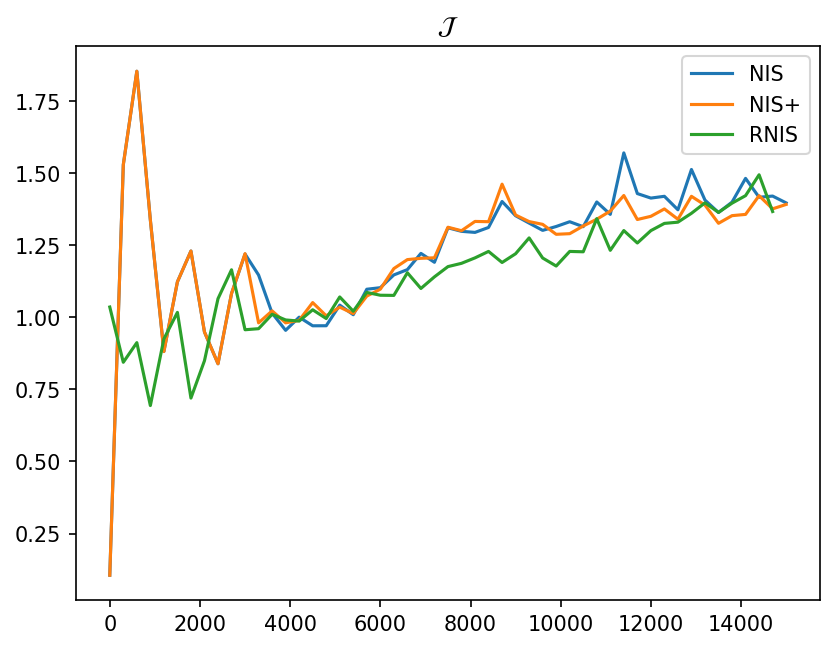

In [16]:
plt.figure(dpi=150)
timeseries = np.arange(len(trainer.eis)) * clip
plt.plot(timeseries, eis_nis, label='NIS')
plt.plot(timeseries, eis_nisp, label='NIS+')
timeseries = np.arange(len(eis_rnis)) * clip
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

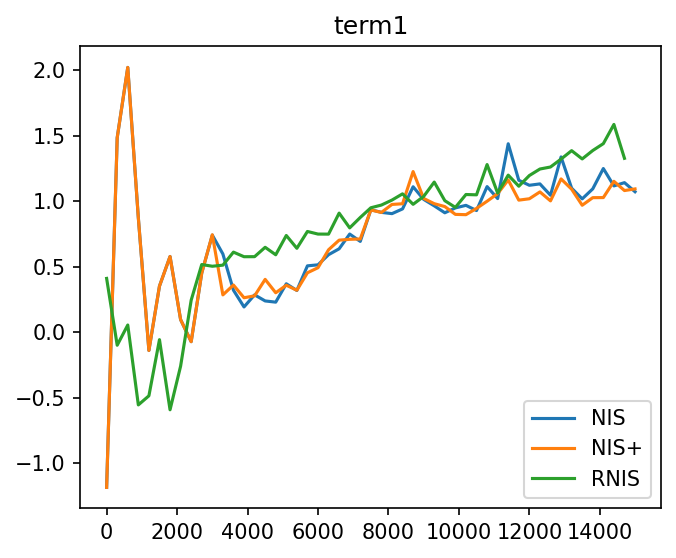

In [18]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term1s_nis, label='NIS')
plt.plot(timeseries, term1s_nisp, label='NIS+')
timeseries = np.arange(len(term1s_rnis)) * clip
plt.plot(timeseries, term1s_rnis, label='RNIS')
plt.title(r'term1')
plt.legend()
# plt.yscale('log')
plt.show()

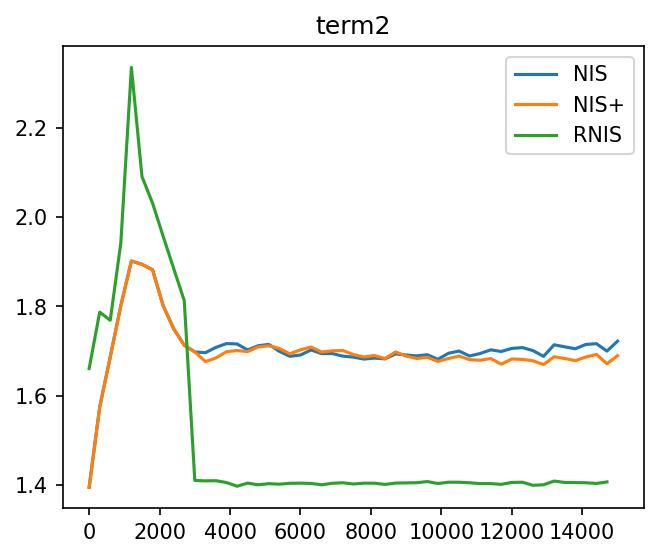

In [19]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term2s_nis, label='NIS')
plt.plot(timeseries, term2s_nisp, label='NIS+')
timeseries = np.arange(len(term2s_rnis)) * clip
plt.plot(timeseries, term2s_rnis, label='RNIS')
plt.title(r'term2')
plt.legend()
# plt.yscale('log')
plt.show()

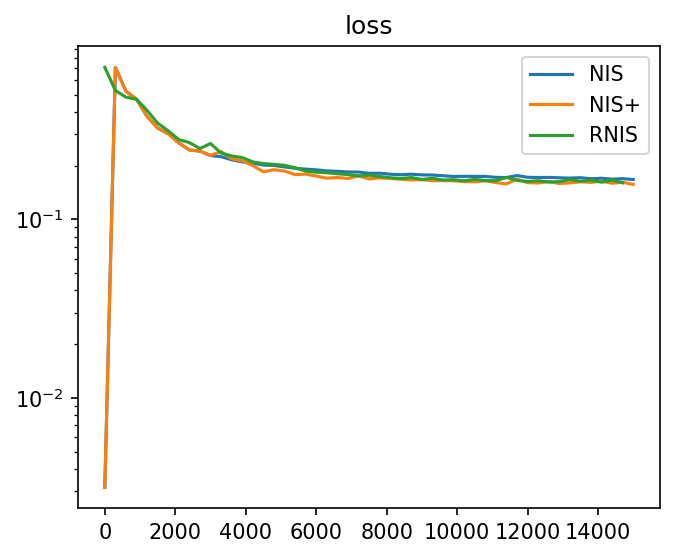

In [20]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, losses_nis, label='NIS')
plt.plot(timeseries, losses_nisp, label='NIS+')
timeseries = np.arange(len(losses_rnis)) * clip
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

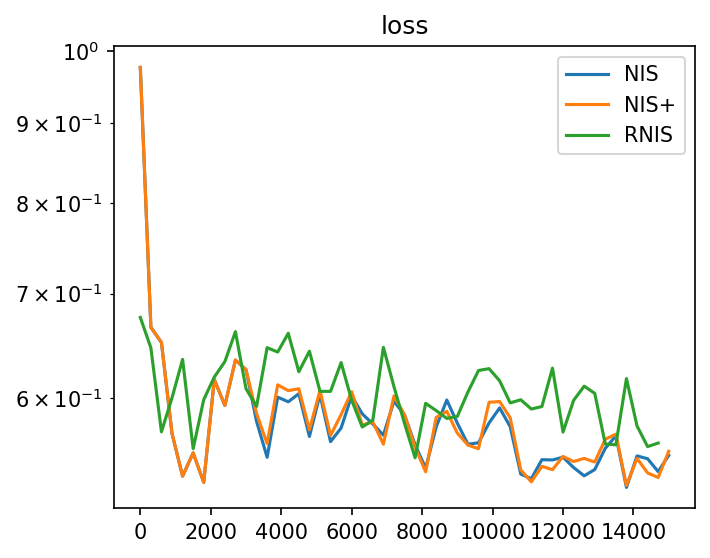

In [21]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
timeseries = np.arange(len(MAEs_mstep_rnis)) * clip
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()